In [ ]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
from pyspark.sql.functions import col, desc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Initialize SparkSession
spark = SparkSession.builder.appName("TubesABD").getOrCreate()

# Read the CSV file with header and infer schema
df = spark.read.csv("C:/Users/evana/Downloads/steam_reviews.csv/steam_reviews.csv", header=True, inferSchema=True, sep=",")

c:\Users\evana\AppData\Local\Programs\Python\Python310\lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [ ]:
# Menampilkan schema DataFrame
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- recommended: string (nullable = true)
 |-- votes_helpful: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- written_during_early_access: string (nullable = true)
 |-- author.steamid: string (nullable = true)
 |-- author.num_games_owned: string (nullable = true)
 |-- author.num_reviews: string (nullable = true)
 |-- author.playtime_forever: string (nullable = true)
 |-- author.playtime_last_two_weeks: string (nullable = true)
 |-- author.playt

In [ ]:
# Tampilkan DataFrame tanpa memotong konten dalam setiap kolom
df.limit(10).toPandas()# Tampilkan DataFrame tanpa memotong konten dalam setiap kolom
df.limit(10).toPandas()

,_c0,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,votes_helpful,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,0,292030,The Witcher 3: Wild Hunt,85185598,schinese,不玩此生遗憾，RPG游戏里的天花板，太吸引人了,1611381629,1611381629,True,0,...,True,False,False,76561199095369542,6,2,1909.0,1448.0,1909.0,1611343383.0
1,1,292030,The Witcher 3: Wild Hunt,85185250,schinese,拔DIAO无情打桩机--杰洛特!!!,1611381030,1611381030,True,0,...,True,False,False,76561198949504115,30,10,2764.0,2743.0,2674.0,1611386307.0
2,2,292030,The Witcher 3: Wild Hunt,85185111,schinese,巫师3NB,1611380800,1611380800,True,0,...,True,False,False,76561199090098988,5,1,1061.0,1061.0,1060.0,1611383777.0
3,3,292030,The Witcher 3: Wild Hunt,85184605,english,"One of the best RPG's of all time, worthy of a...",1611379970,1611379970,True,0,...,True,False,False,76561199054755373,5,3,5587.0,3200.0,5524.0,1611383744.0
4,4,292030,The Witcher 3: Wild Hunt,85184287,schinese,大作,1611379427,1611379427,True,0,...,True,False,False,76561199028326951,7,4,217.0,42.0,217.0,1610788249.0
5,5,292030,The Witcher 3: Wild Hunt,85184171,english,"good story, good graphics. lots to do.",1611379264,1611379264,True,0,...,True,False,False,76561198170193529,11,1,823.0,823.0,823.0,1611379201.0
6,6,292030,The Witcher 3: Wild Hunt,85184064,english,"dis gud,",1611379091,1611379091,True,0,...,True,False,False,76561198119302812,27,2,4192.0,3398.0,4192.0,1611351734.0
7,7,292030,The Witcher 3: Wild Hunt,85183602,turkish,.,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,",1611378312,1611378312,True,0,0,0.0,0,True,Fal...",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
9,8,292030,The Witcher 3: Wild Hunt,85183227,schinese,年度最佳的作品，没啥好夸的，神作,1611377703,1611377703,True,0,...,True,False,False,76561198130808993,581,17,6921.0,222.0,6921.0,1611317275.0


In [ ]:
# Menghitung jumlah baris dalam DataFrame
total_rows = df.count()

# Menampilkan jumlah baris
print(f"Jumlah baris dalam DataFrame: {total_rows}")

Jumlah baris dalam DataFrame: 40848659


In [ ]:
# Hitung jumlah item unik dalam kolom "app_name"
unique_app_count = df.groupBy("app_name").count()

# Urutkan DataFrame berdasarkan kolom "count" secara descending
sorted_unique_app_count = unique_app_count.orderBy(desc("count"))

sorted_unique_app_count.show(truncate=False)

+------------------------------+--------+
|app_name                      |count   |
+------------------------------+--------+
|NULL                          |13077913|
|PLAYERUNKNOWN'S BATTLEGROUNDS |1644255 |
|Grand Theft Auto V            |1019116 |
|Tom Clancy's Rainbow Six Siege|841918  |
|Terraria                      |672817  |
|Garry's Mod                   |655524  |
|Rust                          |549075  |
|Rocket League                 |498565  |
|PAYDAY 2                      |487747  |
|Among Us                      |485293  |
|The Witcher 3: Wild Hunt      |469395  |
|Dead by Daylight              |418897  |
|ARK: Survival Evolved         |400009  |
|Euro Truck Simulator 2        |387553  |
|Stardew Valley                |315717  |
|The Elder Scrolls V: Skyrim   |294966  |
|Wallpaper Engine              |292790  |
|Monster Hunter: World         |290946  |
|Hollow Knight                 |269854  |
|The Forest                    |239734  |
+------------------------------+--

In [ ]:
# Filter DataFrame for app name "PLAYERUNKNOWN'S BATTLEGROUNDS" with language = "english" and non-null or non-empty reviews
pubg_df_clean = df.filter((col("app_name") == "PLAYERUNKNOWN'S BATTLEGROUNDS") &
                          (col("language") == "english") &
                          (col("review").isNotNull()) &
                          (col("review") != ""))

# Select only the "review" column
pubg_reviews = pubg_df_clean.select("review")

# Convert Spark DataFrame to Pandas DataFrame
pubg_reviews_pd = pubg_reviews.toPandas()

# Tampilkan DataFrame untuk ulasan PLAYERUNKNOWN'S BATTLEGROUNDS
print("\nDataFrame untuk ulasan PLAYERUNKNOWN'S BATTLEGROUNDS:")
pubg_reviews_pd.sample(10)


DataFrame untuk ulasan PLAYERUNKNOWN'S BATTLEGROUNDS:


,review
4532,erangel!!!
100656,"Without the doubt, the worst game ever made."
119480,first review on steam because I feel like pubg...
4017,Game won't even launch...
210153,Cool game
248296,"Graphics look like absolute ass, game runs lik..."
276958,I just Tom Clancy'd the shit out of this guy i...
225164,"This game is really fun to play at its core, y..."
123572,"I wish I could refund, this shit game got so m..."
155177,much crash and bug


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Mengunduh data yang diperlukan
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\evana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\evana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\evana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\evana\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from nltk.stem import WordNetLemmatizer

# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing
def preprocess_text(text):
    # Case folding
    text = text.lower()

    # Tokenizing
    tokens = word_tokenize(text)

    # Removing punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [word.translate(table) for word in tokens]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    additional_stopwords = {'game', 'play', 'good', 'bad', 'like', 'one', 'get', 'make', 'go', 'time'}
    all_stopwords = stop_words.union(additional_stopwords)
    tokens = [word for word in tokens if word not in all_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing to the 'review' column
pubg_reviews_pd['review'] = pubg_reviews_pd['review'].apply(preprocess_text)


In [ ]:
# Initialize VADER sentiment analyzer
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Apply preprocessing to the 'review' column
pubg_reviews_pd['review'] = pubg_reviews_pd['review'].apply(preprocess_text)

# Function to analyze sentiment using VADER
def analyze_sentiment(text):
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.05:
        return 'Positive'
    elif scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment analysis to each review
pubg_reviews_pd['sentiment'] = pubg_reviews_pd['review'].apply(analyze_sentiment)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\evana\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Hitung jumlah review untuk setiap label sentimen
sentiment_counts = pubg_reviews_pd['sentiment'].value_counts()

# Print jumlah review untuk setiap label sentimen
print("Sentimen Positif:", sentiment_counts['Positive'])
print("Sentimen Negatif:", sentiment_counts['Negative'])
print("Sentimen Netral:", sentiment_counts['Neutral'])


Sentimen Positif: 138129
Sentimen Negatif: 80135
Sentimen Netral: 99379


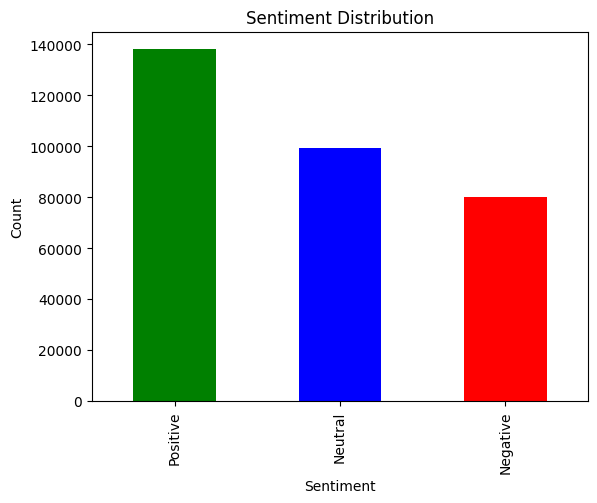

In [ ]:
# Visualize sentiment distribution
sentiment_counts = pubg_reviews_pd['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

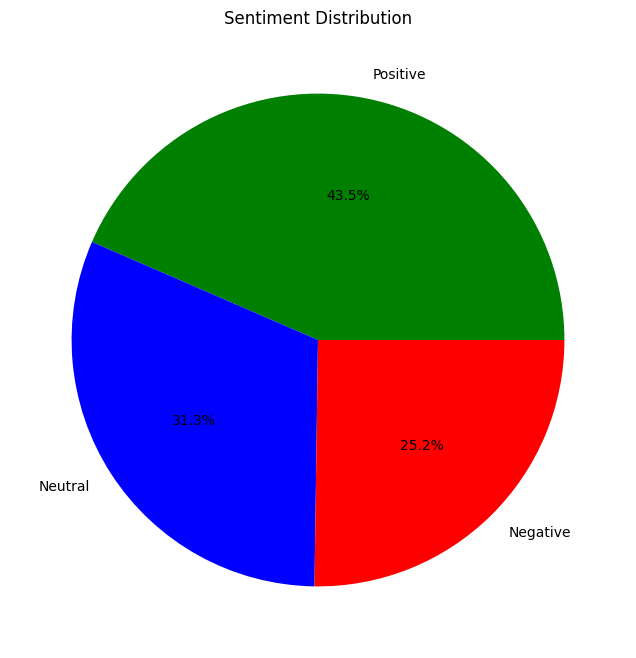

In [ ]:
# Pie chart of sentiment distribution
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'blue', 'red'])
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.show()

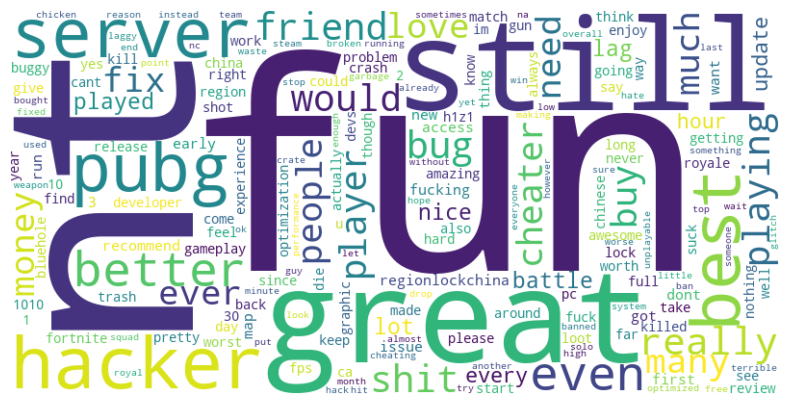

In [ ]:
# Join preprocessed reviews into a single text
all_reviews_text = " ".join(pubg_reviews_pd["review"])

# Calculate word frequencies
word_freq = Counter(all_reviews_text.split())

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Show WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

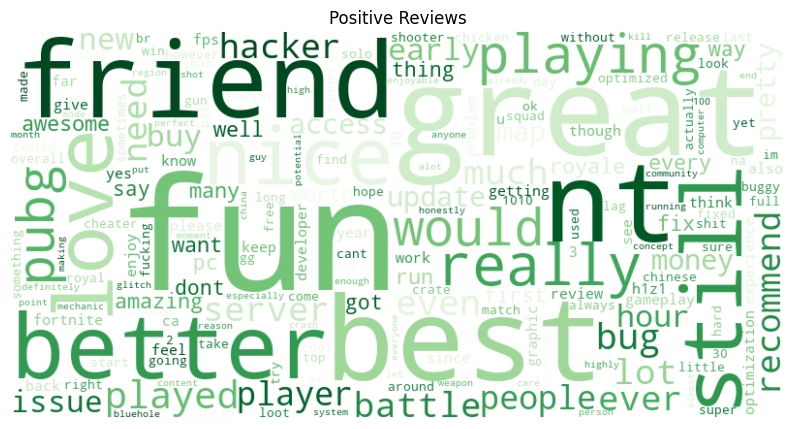

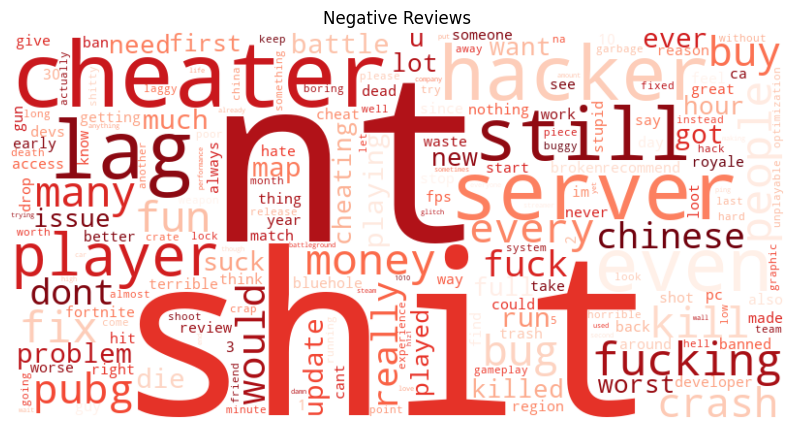

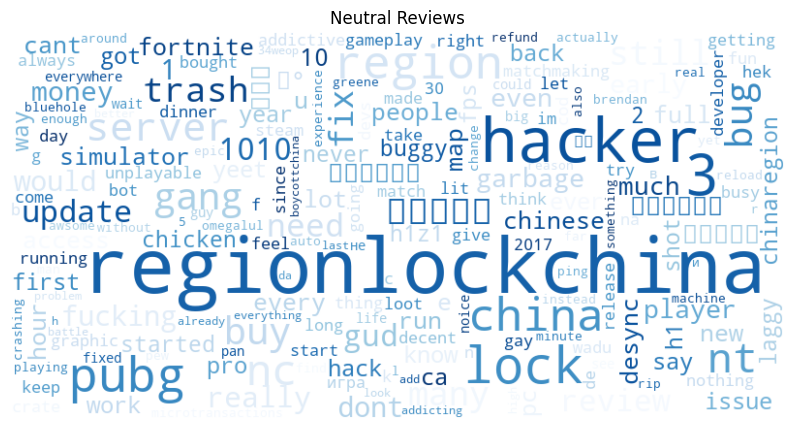

In [ ]:
# Join preprocessed reviews into a single text for each sentiment category
positive_reviews_text = ' '.join(pubg_reviews_pd[pubg_reviews_pd['sentiment'] == 'Positive']['review'].tolist())
negative_reviews_text = ' '.join(pubg_reviews_pd[pubg_reviews_pd['sentiment'] == 'Negative']['review'].tolist())
neutral_reviews_text = ' '.join(pubg_reviews_pd[pubg_reviews_pd['sentiment'] == 'Neutral']['review'].tolist())

# Calculate word frequencies for each sentiment category
positive_word_freq = Counter(positive_reviews_text.split())
negative_word_freq = Counter(negative_reviews_text.split())
neutral_word_freq = Counter(neutral_reviews_text.split())

# Create WordCloud for each sentiment category
positive_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(positive_word_freq)
negative_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(negative_word_freq)
neutral_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(neutral_word_freq)

# Plot WordCloud for each sentiment category
plt.figure(figsize=(10, 15))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 15))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 15))
plt.imshow(neutral_wordcloud, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis('off')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Map sentiment labels to numerical values
sentiment_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
pubg_reviews_pd['sentiment'] = pubg_reviews_pd['sentiment'].map(sentiment_mapping)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pubg_reviews_pd['review'], pubg_reviews_pd['sentiment'], test_size=0.2, random_state=42)

# Define the pipelines
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train and evaluate each model
for pipe, name in zip([pipeline_nb, pipeline_lr], ['Naive Bayes', 'Logistic Regression']):
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Print accuracy and classification report
    print(f"\n{name} Model")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))



Naive Bayes Model
Accuracy: 0.7196870720458374
Classification Report:
               precision    recall  f1-score   support

          -1       0.83      0.76      0.79     16153
           0       0.84      0.43      0.57     19789
           1       0.65      0.91      0.75     27587

    accuracy                           0.72     63529
   macro avg       0.77      0.70      0.70     63529
weighted avg       0.75      0.72      0.71     63529


Logistic Regression Model
Accuracy: 0.9488894835429489
Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.91      0.92     16153
           0       0.96      0.97      0.96     19789
           1       0.95      0.96      0.96     27587

    accuracy                           0.95     63529
   macro avg       0.95      0.95      0.95     63529
weighted avg       0.95      0.95      0.95     63529



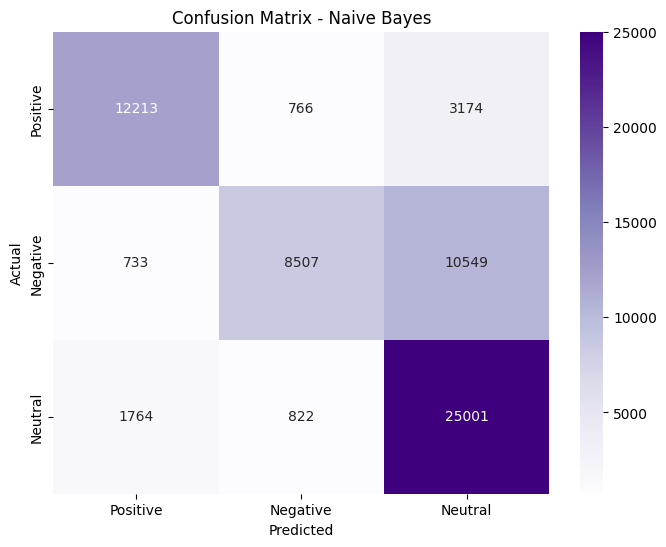

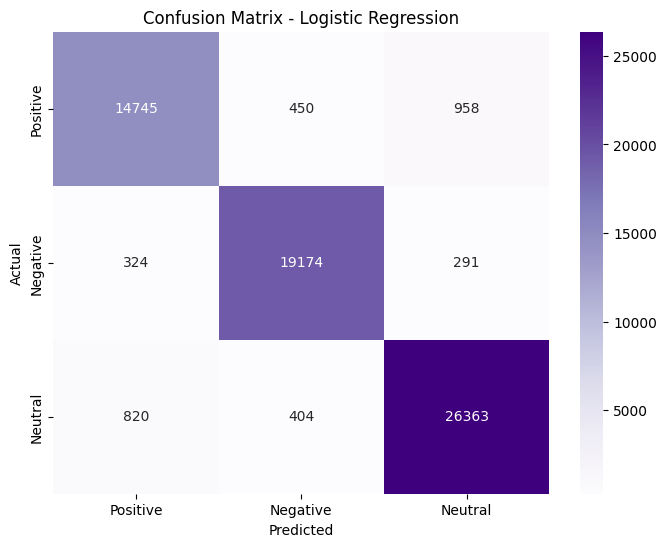

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
for pipe, name in zip([pipeline_nb, pipeline_lr], ['Naive Bayes', 'Logistic Regression']):
    y_pred = pipe.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=sentiment_mapping.keys(), yticklabels=sentiment_mapping.keys())
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
